In [1]:
import sys, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow')))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
import pickle

import tensorflow as tf

In [2]:
from bayesflow import benchmarks
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork, DeepSet
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_sbc_ecdf, plot_recovery, plot_posterior_2d, plot_losses, plot_latent_space_2d

/home/jupyter/BayesFlow/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Benchmark: Bernoulli GLM Raw

In [3]:
benchmark_name = 'bernoulli_glm_raw'
benchmark = benchmarks.Benchmark(benchmark_name)

INFO:root:Performing 2 pilot runs with the bernoulli_glm_raw model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 10)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 10)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Amortizer and Trainer

In [25]:
# Summary network will be a small permutation-invariant network
summary_net = DeepSet(32)

# Amortizer setup
amortizer = AmortizedPosteriorLikelihood(
# Posterior amortizer
    AmortizedPosterior(
        inference_net=InvertibleNetwork(
            num_params=10, 
            num_coupling_layers=6, 
            coupling_design='spline', 
            permutation='learnable'
        ),
        summary_net=summary_net
    ),
# Likelihood amortizer
    AmortizedLikelihood(
        InvertibleNetwork(
            num_params=2, 
            num_coupling_layers=6, 
            coupling_design='spline', 
            use_soft_flow=True)
    )
)

In [26]:
trainer = Trainer(
    amortizer=amortizer,
    generative_model=benchmark.generative_model,
    configurator=partial(benchmark.configurator, as_summary_condition=True),
    checkpoint_path=f'checkpoints/{benchmark_name}',
    memory=False,
    max_to_keep=1
)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Training
Uncomment for training.

In [27]:
EPOCHS = 50
SIMULATION_BUDGET = 10000
N_VAL = 300
BATCH_SIZE = 32

train_data = trainer.generative_model(SIMULATION_BUDGET)

In [28]:
%%time
h = trainer.train_offline(train_data, EPOCHS, BATCH_SIZE, validation_sims=N_VAL)

INFO:root:Generated 300 simulations for validation.


Training epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Post.Loss: 11.199, Lik.Loss: -0.169


Training epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Post.Loss: 10.288, Lik.Loss: -0.724


Training epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Post.Loss: 10.115, Lik.Loss: -0.940


Training epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Post.Loss: 9.738, Lik.Loss: -0.933


Training epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Post.Loss: 9.820, Lik.Loss: -1.129


Training epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Post.Loss: 8.849, Lik.Loss: -1.388


Training epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Post.Loss: 8.329, Lik.Loss: -1.801


Training epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Post.Loss: 8.513, Lik.Loss: -2.036


Training epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Post.Loss: 8.205, Lik.Loss: -2.013


Training epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Post.Loss: 7.978, Lik.Loss: -2.162


Training epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Post.Loss: 7.668, Lik.Loss: -2.208


Training epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Post.Loss: 7.387, Lik.Loss: -1.958


Training epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Post.Loss: 7.260, Lik.Loss: -2.349


Training epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Post.Loss: 7.221, Lik.Loss: -2.365


Training epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Post.Loss: 6.992, Lik.Loss: -2.326


Training epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Post.Loss: 7.040, Lik.Loss: -2.361


Training epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Post.Loss: 6.962, Lik.Loss: -2.283


Training epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Post.Loss: 6.896, Lik.Loss: -2.420


Training epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Post.Loss: 6.991, Lik.Loss: -2.450


Training epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Post.Loss: 6.905, Lik.Loss: -2.339


Training epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Post.Loss: 6.872, Lik.Loss: -2.491


Training epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Post.Loss: 6.957, Lik.Loss: -2.444


Training epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Post.Loss: 6.865, Lik.Loss: -2.490


Training epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Post.Loss: 6.893, Lik.Loss: -2.517


Training epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Post.Loss: 6.905, Lik.Loss: -2.517


Training epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Post.Loss: 6.878, Lik.Loss: -2.593


Training epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Post.Loss: 6.857, Lik.Loss: -2.480


Training epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Post.Loss: 7.001, Lik.Loss: -2.569


Training epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Post.Loss: 6.870, Lik.Loss: -2.499


Training epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Post.Loss: 6.832, Lik.Loss: -2.613


Training epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Post.Loss: 6.884, Lik.Loss: -2.584


Training epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Post.Loss: 6.886, Lik.Loss: -2.661


Training epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Post.Loss: 7.015, Lik.Loss: -2.610


Training epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Post.Loss: 6.929, Lik.Loss: -2.627


Training epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Post.Loss: 6.901, Lik.Loss: -2.674


Training epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Post.Loss: 6.920, Lik.Loss: -2.673


Training epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Post.Loss: 6.888, Lik.Loss: -2.664


Training epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Post.Loss: 6.875, Lik.Loss: -2.668


Training epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Post.Loss: 6.885, Lik.Loss: -2.685


Training epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Post.Loss: 6.870, Lik.Loss: -2.671


Training epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Post.Loss: 6.869, Lik.Loss: -2.686


Training epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Post.Loss: 6.872, Lik.Loss: -2.691


Training epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Post.Loss: 6.879, Lik.Loss: -2.704


Training epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Post.Loss: 6.880, Lik.Loss: -2.692


Training epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Post.Loss: 6.873, Lik.Loss: -2.696


Training epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Post.Loss: 6.871, Lik.Loss: -2.703


Training epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Post.Loss: 6.871, Lik.Loss: -2.704


Training epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Post.Loss: 6.871, Lik.Loss: -2.710


Training epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Post.Loss: 6.875, Lik.Loss: -2.706


Training epoch 50:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Post.Loss: 6.877, Lik.Loss: -2.707


CPU times: user 53min, sys: 10min 24s, total: 1h 3min 25s
Wall time: 32min 41s


# Validation

## Loss Trajectories

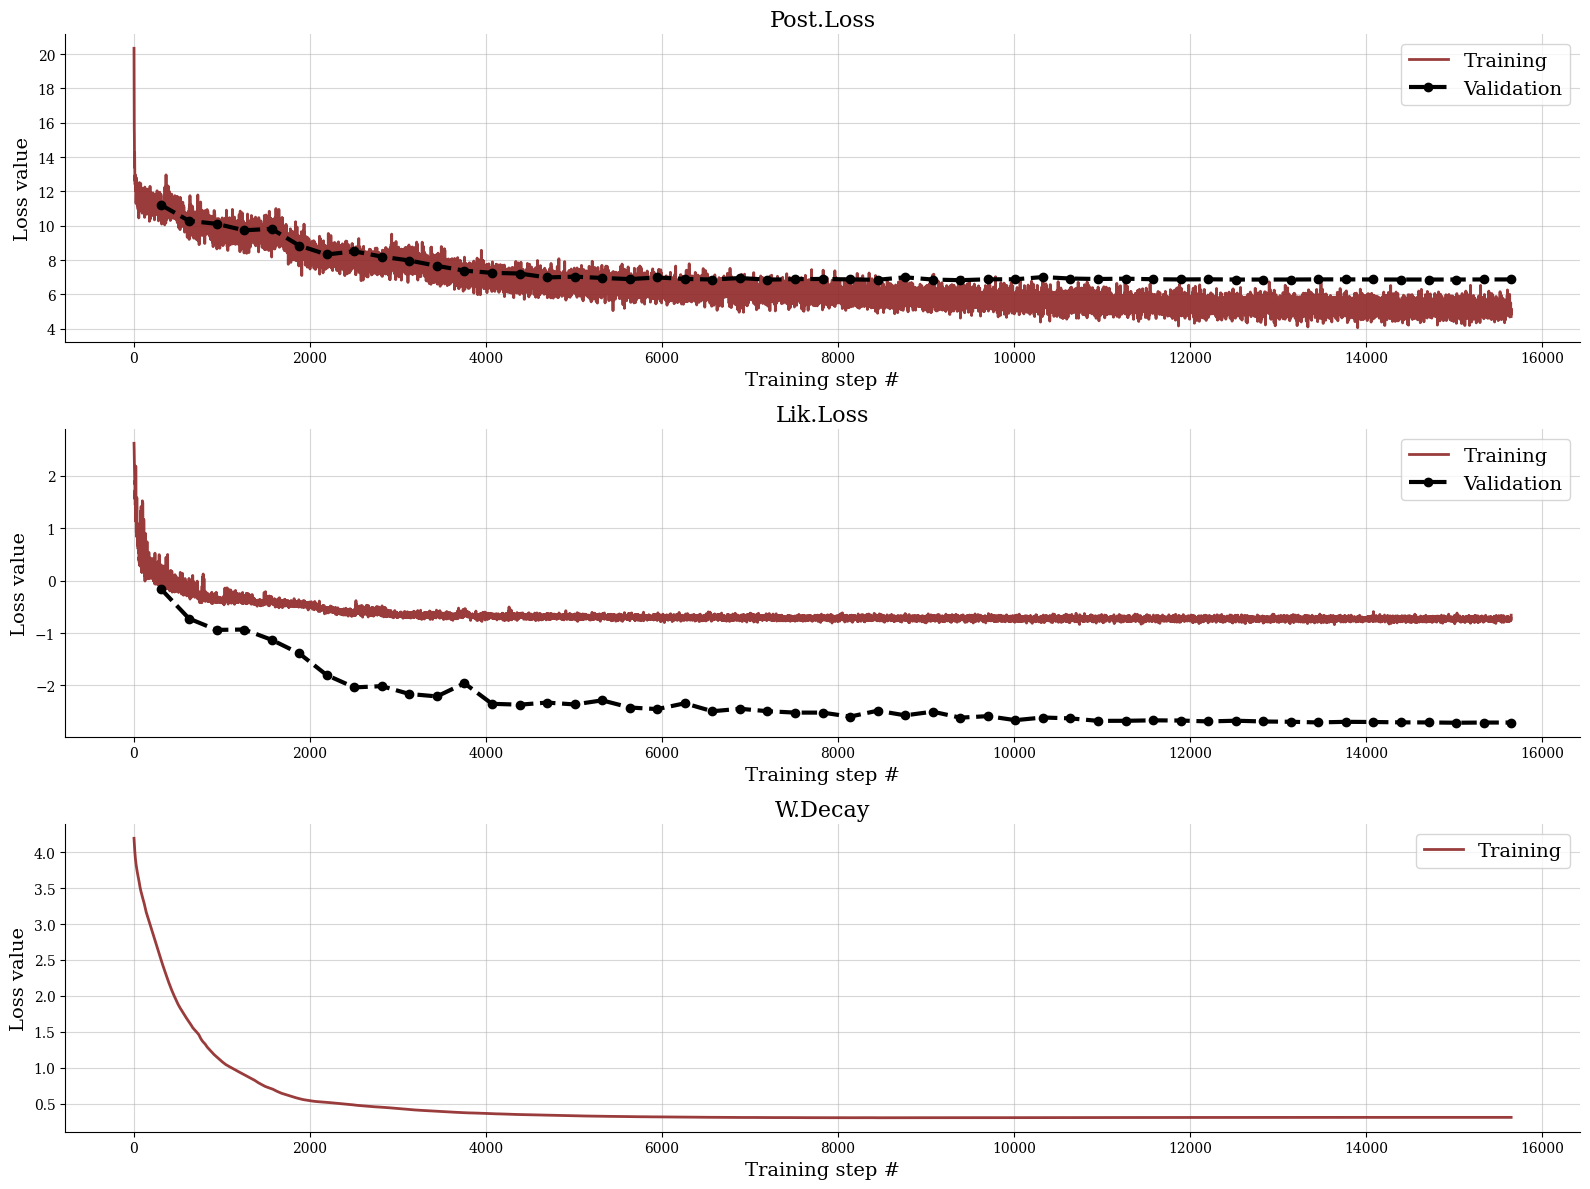

In [31]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])

In [32]:
# Load test data
with open(f'test_data/{benchmark_name}_test.pkl', 'rb') as f:
    test_dict = pickle.load(f)

In [33]:
num_post_samples = 250

# Simulate from surrogate simulator
x_sim_s = amortizer.sample_data(test_dict, n_samples=100)[:, :, 0:1]
x_sim_s = np.abs(np.round(x_sim_s))

# Sample from posteriors given surrogate outputs
cond = test_dict['posterior_inputs']['summary_conditions'][:, :, 1:]
cond = np.concatenate([x_sim_s, cond], axis=-1)
post_samples_s = amortizer.sample_parameters({'summary_conditions': cond}, n_samples=num_post_samples)

# Sample from posteriors given simulator outputs
post_samples = amortizer.sample_parameters(test_dict, n_samples=num_post_samples)

# Prior samples
prior_samples = test_dict['posterior_inputs']['parameters']

## Calibration

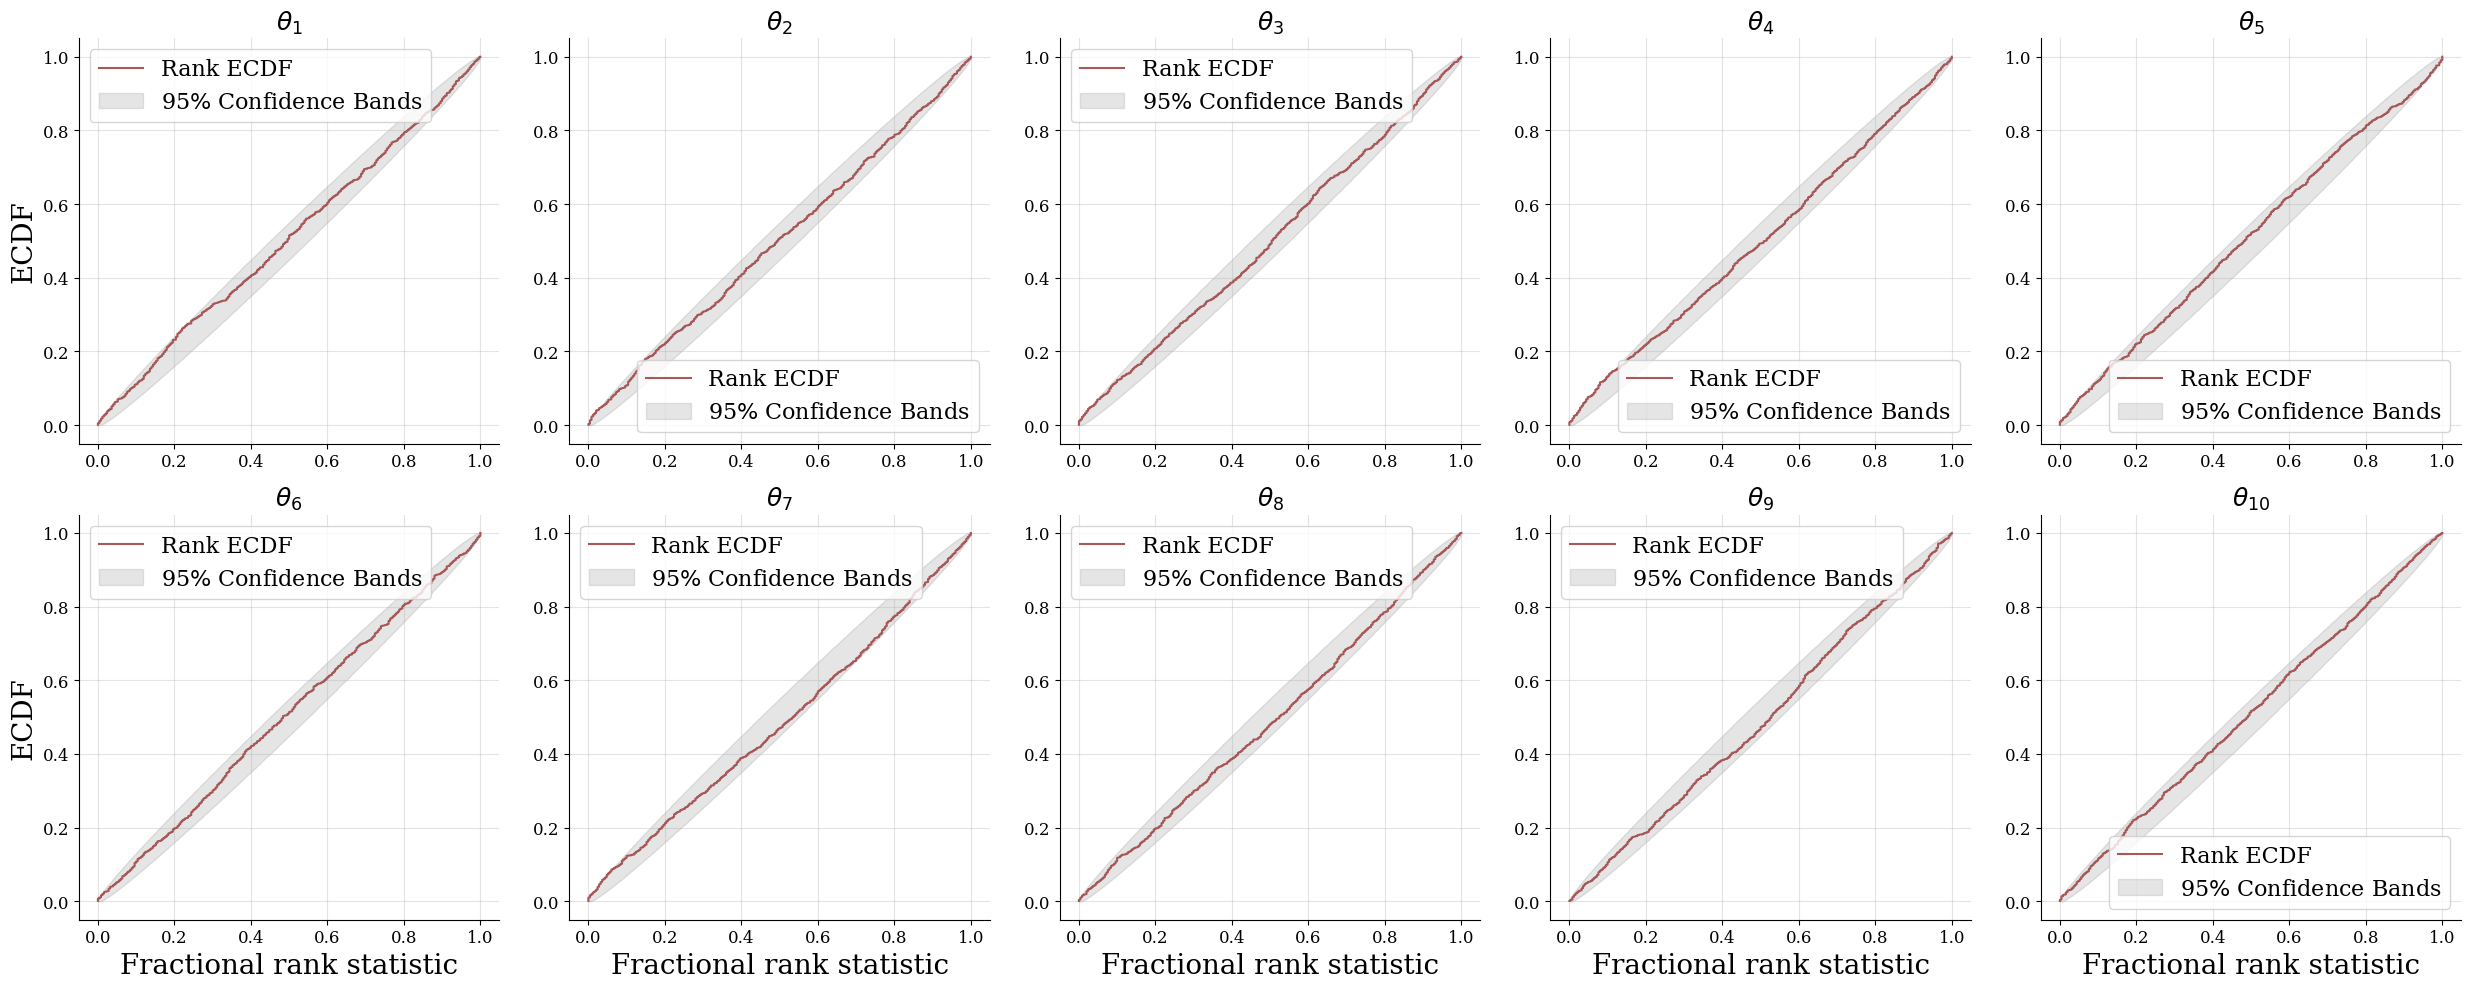

In [34]:
f = plot_sbc_ecdf(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95), label_fontsize=20, legend_fontsize=16)

## Recovery

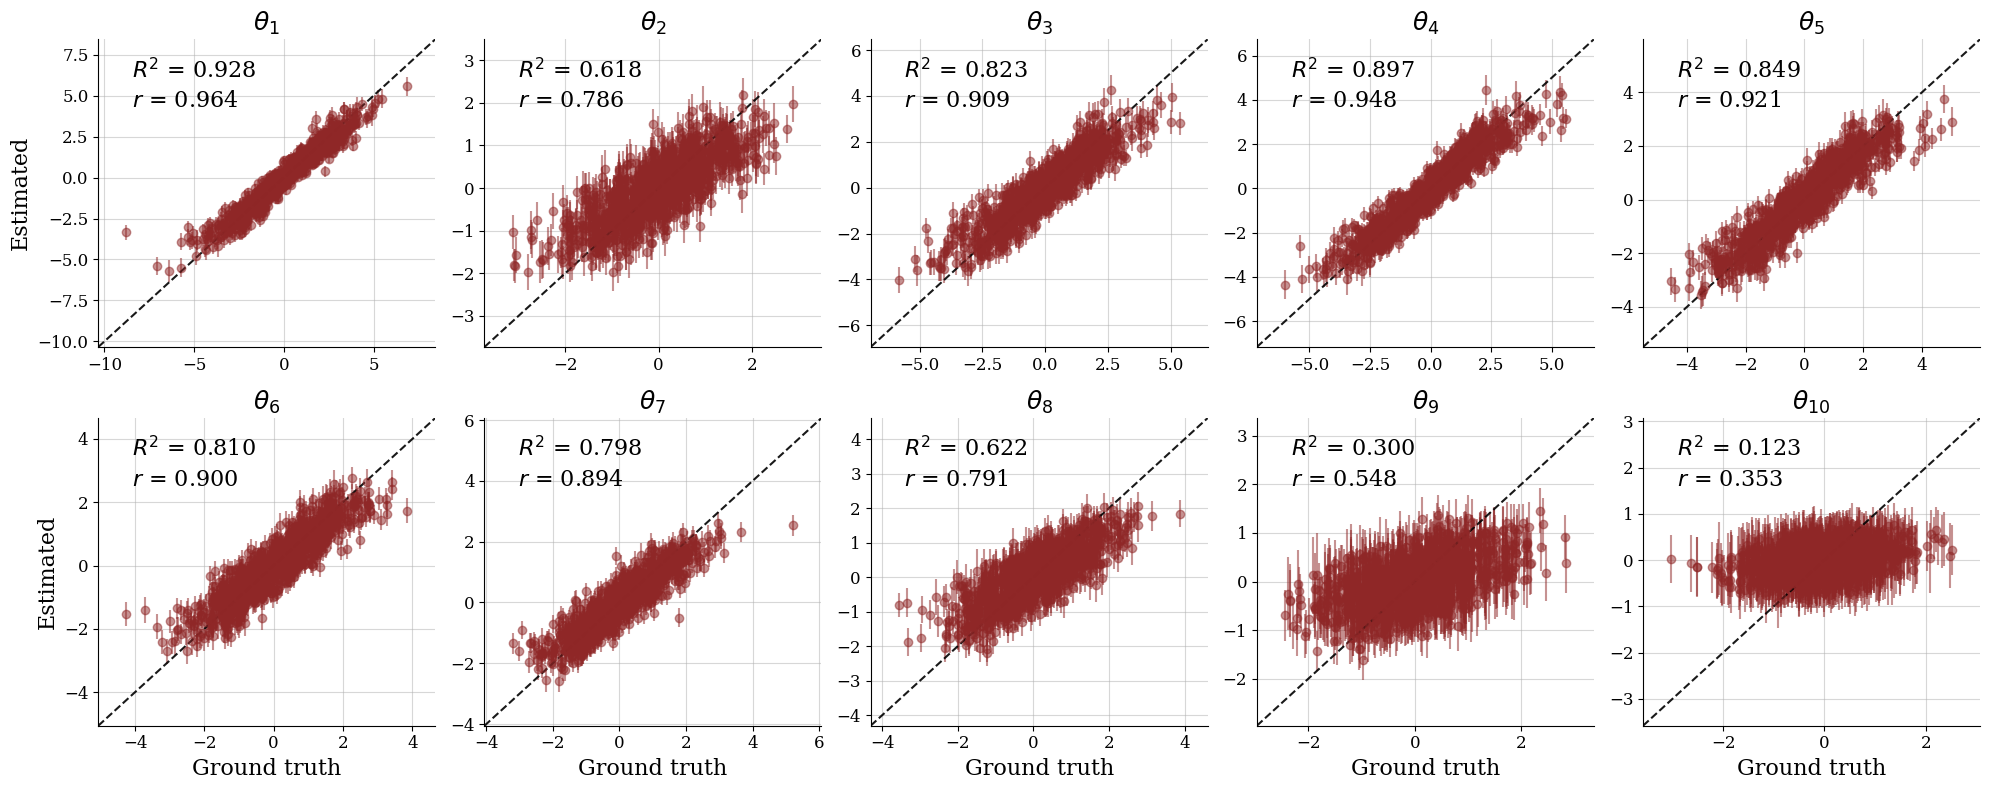

In [40]:
f = plot_recovery(post_samples, prior_samples)

# Appendix Plots

In [36]:
# load custom tighter plotting function
from custom_plots import plot_sbc_ecdf_appendix

# adjust for better readability
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

### Loss History

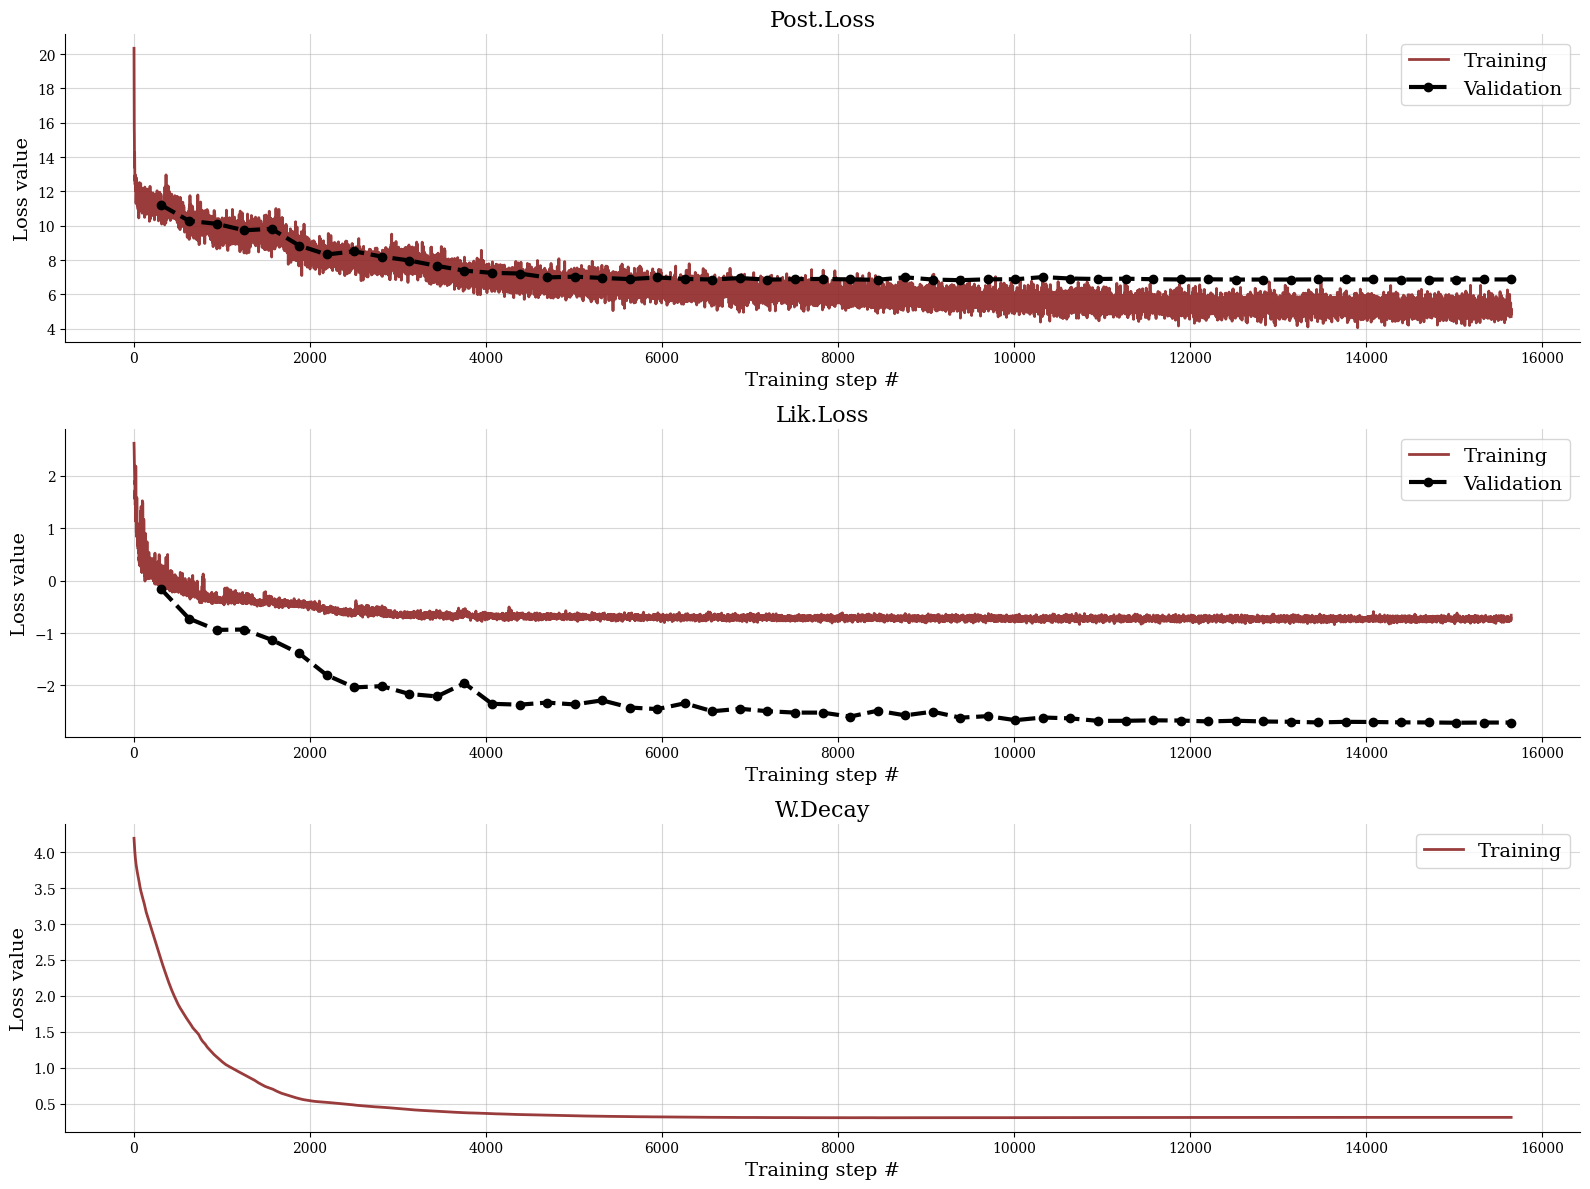

In [37]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])
plt.savefig(f"figures/{benchmark_name}_losses.pdf", dpi=300, bbox_inches="tight")

### Posterior Calibration

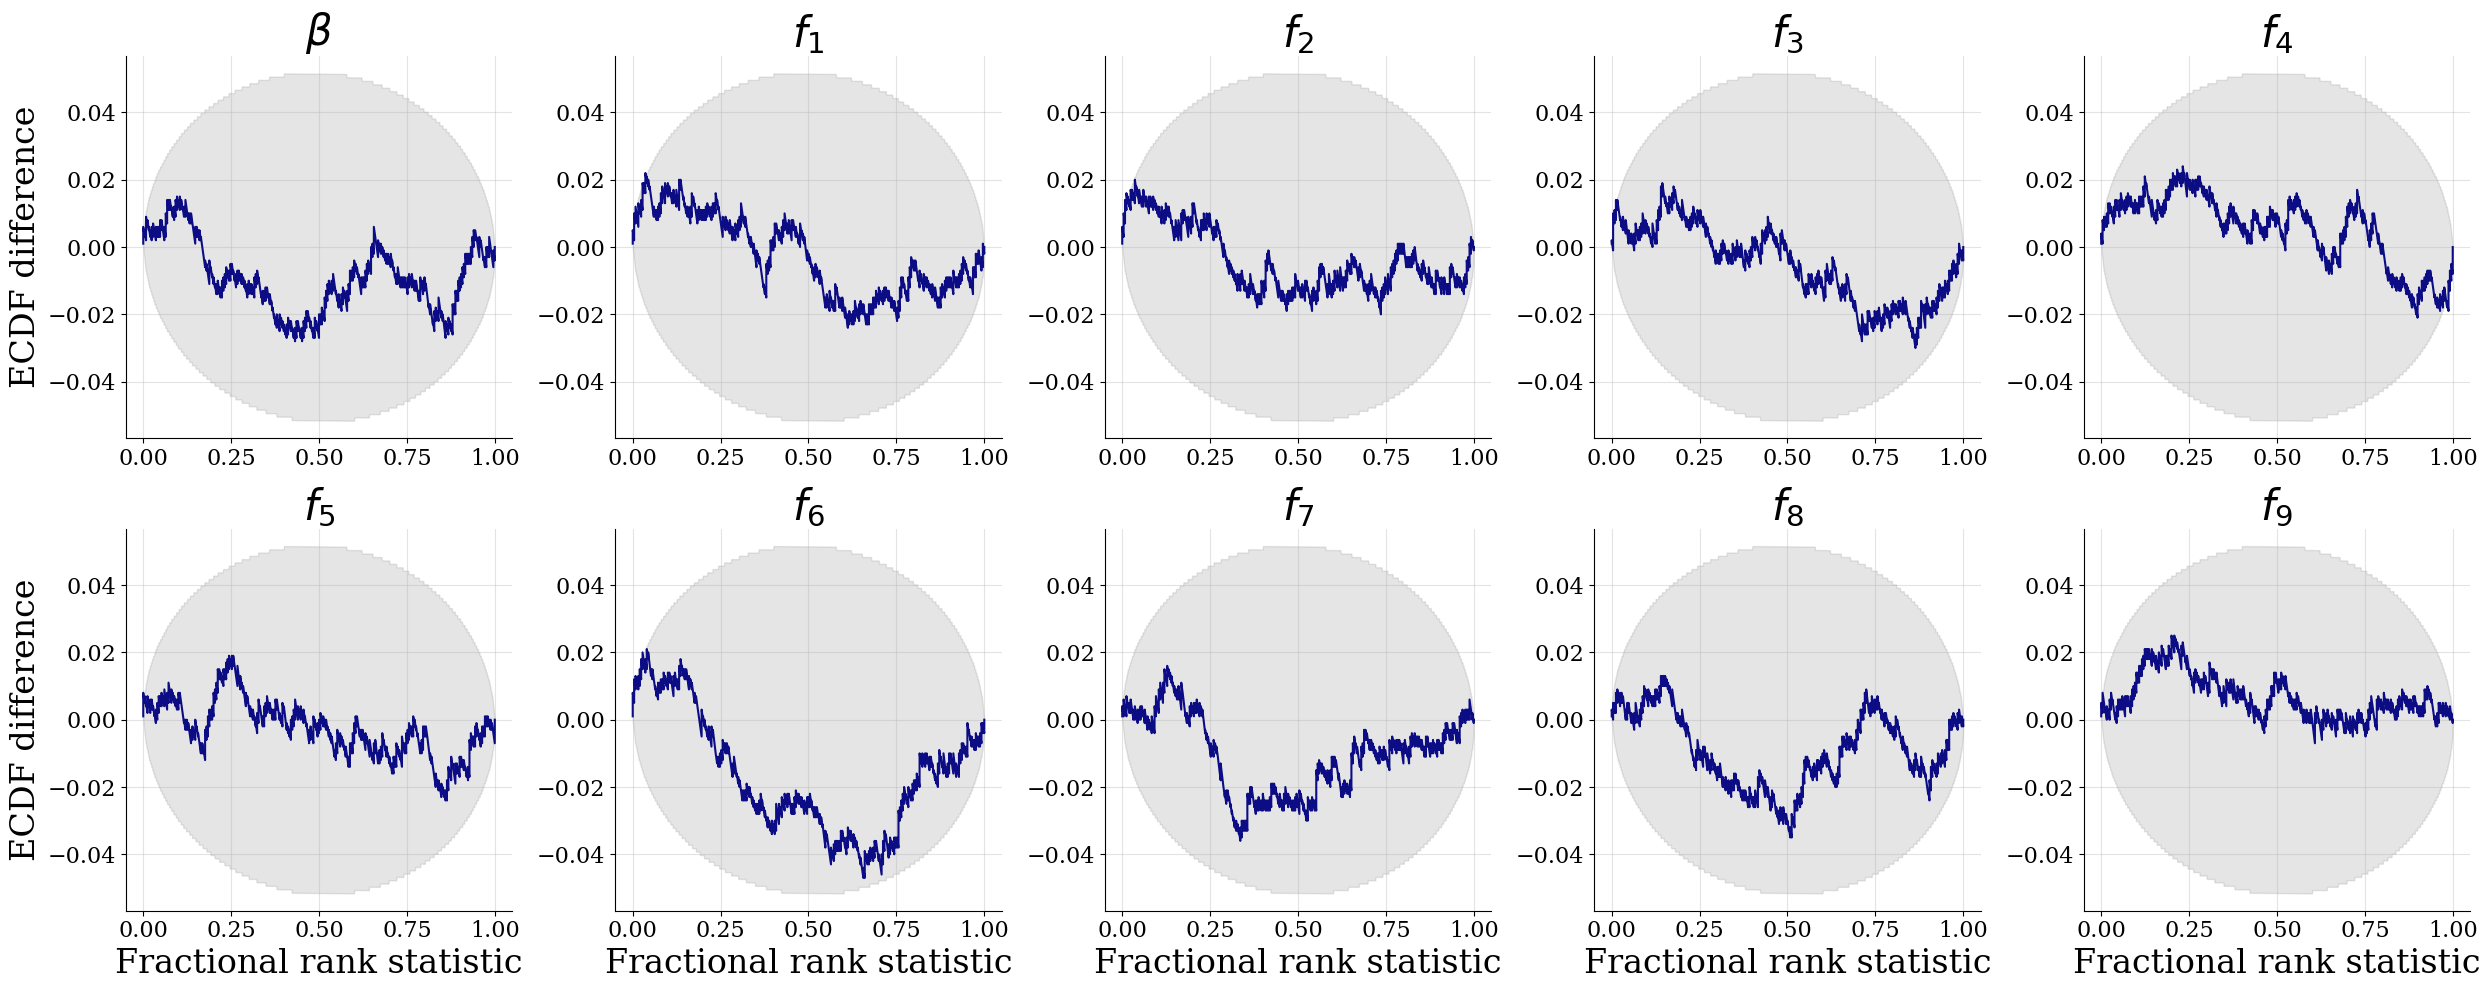

In [38]:
f = plot_sbc_ecdf_appendix(
    post_samples, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=benchmark.benchmark_info['parameter_names'],
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#000080'
)

plt.savefig(f"figures/{benchmark_name}_posterior_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")

### Joint Calibration

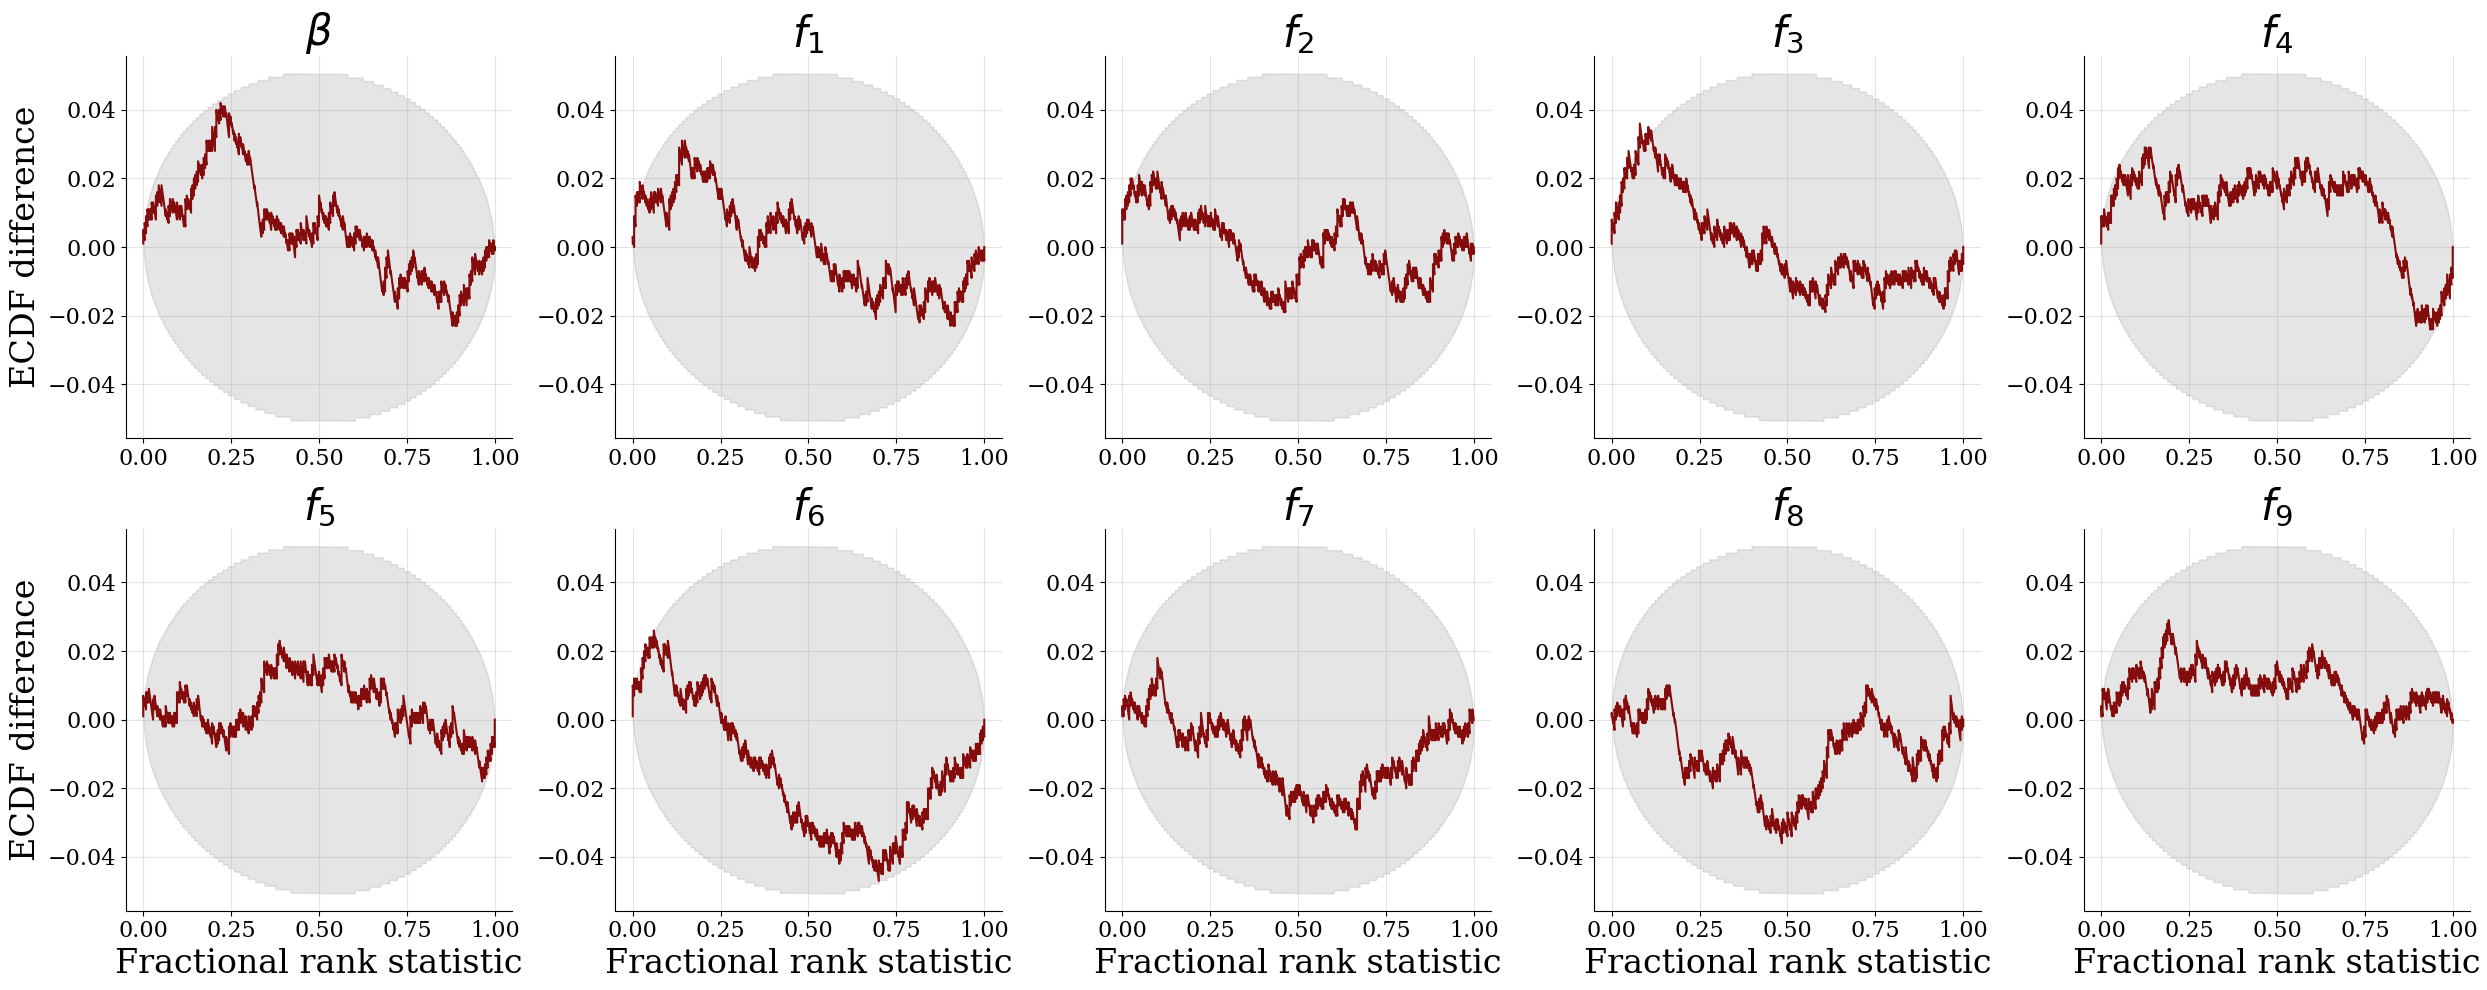

In [39]:
f = plot_sbc_ecdf_appendix(
    post_samples_s, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=benchmark.benchmark_info['parameter_names'],
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#800000'
)

plt.savefig(f"figures/{benchmark_name}_joint_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")